In [2]:
%matplotlib inline
import os, sqlite3
import pandas as pd
import matplotlib.pyplot as plt
# DB = os.environ.get('DB', '../db.sqlite')
DB = os.environ.get('DB', '../db_preprocessed.sqlite')
db = sqlite3.connect(DB)
db.row_factory = lambda x,y: dict(sqlite3.Row(x,y))
cur = db.cursor()

from matplotlib import rc
import matplotlib.pylab as plt
rc('font', **{'family': 'sans-serif'})
rc('text', usetex=False)

# Pivots

In [3]:
%%time 
df = pd.read_sql("SELECT headerId AS h, COUNT(*) AS c FROM tables GROUP BY headerId ORDER BY c DESC", db)
df['i'] = df.index
print(len(df), 'headers, of which non-singleton:', sum(df['c']>1))

330221 headers, of which non-singleton: 82818
CPU times: user 1.92 s, sys: 218 ms, total: 2.13 s
Wall time: 8.66 s


In [4]:
%%time 
df2 = pd.read_sql("""
SELECT IFNULL(p.pivotedHeaderId, t.headerId) AS h, COUNT(*) AS c 
FROM tables AS t 
LEFT OUTER JOIN pivots AS p ON (t.headerId=p.headerId) 
GROUP BY h
ORDER BY c DESC
""", db)
df2['i'] = df2.index
print(len(df2), 'headers, of which non-singleton:', sum(df2['c']>1))

246087 headers, of which non-singleton: 71349
CPU times: user 2.46 s, sys: 183 ms, total: 2.64 s
Wall time: 2.65 s


In [5]:
df_ = df2[['h','c']].merge(df[['h','c']], how='inner', on='h')
print(len(df_), 'headers both in pivoted and original')

69738 headers both in pivoted and original


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


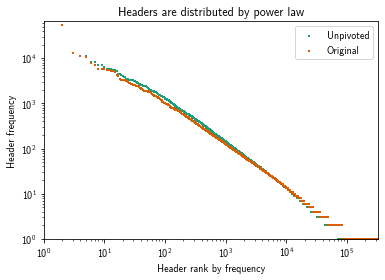

In [6]:
df_ = df2[['i','c']].merge(df[['i','c']], how='outer', on='i')
fig, ax = plt.subplots()
for i,(c,l) in enumerate([('c_x','Unpivoted'),('c_y', 'Original')]):
    ax.scatter(df_['i'], df_[c], marker='+', label=l, s=3, c=plt.cm.Dark2(i) )
ax.loglog()
ax.set_xlabel('Header rank by frequency')
ax.set_ylabel('Header frequency')
ax.set_title('Headers are distributed by power law')
ax.legend()
ax.set(xlim=[1,max(df['i'])], ylim=[1,max(df['c'])])
None

'lmsans10-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'lmsans10-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


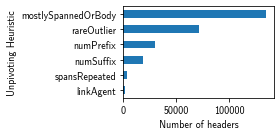

'lmsans10-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'lmsans10-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


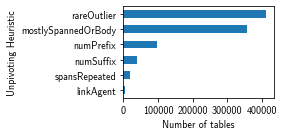

Total headers:  260528
Total headers:  933949


h       n  nTables
0            linkAgent    1723     5025
1  mostlySpannedOrBody  135318   356297
2            numPrefix   29585    98257
3            numSuffix   18417    40604
4          rareOutlier   71570   413507
5        spansRepeated    3915    20259

In [7]:
from matplotlib import rc
import matplotlib.pylab as plt
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Latin Modern Sans']})
rc('text', usetex=False)
# rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
# rc('text', usetex=True)

df = pd.read_sql("""
SELECT 
    (CASE INSTR(heuristic, " ") WHEN 0 THEN heuristic ELSE SUBSTR(heuristic, 0, INSTR(heuristic, " ")) END) AS h, 
    COUNT(DISTINCT pivots.headerId) AS n,
    COUNT(DISTINCT tables.pgId || '-' || tables.tbNr) AS nTables
FROM pivots
JOIN tables ON (tables.headerId = pivots.headerId)
GROUP BY h
""", db)

fig = plt.figure(figsize=(4,2))
ax = df.set_index('h').sort_values('n', ascending=True)['n'].plot.barh()
ax.set(ylabel='Unpivoting Heuristic', xlabel='Number of headers')
plt.tight_layout()
plt.savefig('../paper/img/pivotcount.pdf', bbox_inches='tight')
plt.show()

fig = plt.figure(figsize=(4,2))
ax = df.set_index('h').sort_values('nTables', ascending=True)['nTables'].plot.barh()
ax.set(ylabel='Unpivoting Heuristic', xlabel='Number of tables')
plt.tight_layout()
plt.savefig('../paper/img/pivotcount-tables.pdf', bbox_inches='tight')
plt.show()

print('Total headers pivoted: ', df['n'].sum())
print('Total tables pivoted: ', df['nTables'].sum())

df

## Pivot scores

In [8]:
username_gold = 'sample-A-benno'
# username_pred = 'output/sample-A/8nov//baseline-pivots'
username_pred = 'output/sample-A/10jan//baseline-pivots'
username_pred = 'output/sample-A/18jan//baseline-pivots'

annotated_pivots = cur.execute("""
SELECT t.pgId, t.tbNr, ap.headerId, ap.pivotedHeaderId
FROM annotation_pivots AS ap
JOIN tables AS t ON (t.headerId=ap.headerId)
JOIN annotation_tables AS at ON (at.user=ap.user) AND (t.pgId=at.pgId) AND (t.tbNr=at.tbNr)
WHERE (ap.user=?) AND (pivotedHeaderId > 0)
""", [username_gold]).fetchall()

discarded_tables = cur.execute("""
SELECT pgId, tbNr
FROM annotation_log AS al
WHERE (user=?) AND (accepted=0) AND (clusterId IS NULL)
""", [username_gold]).fetchall()
discarded_tables = set([(t['pgId'], t['tbNr']) for t in discarded_tables])

annotated_pivots = [t for t in annotated_pivots if (t['pgId'], t['tbNr']) not in discarded_tables]

r = cur.execute("""
SELECT t.pgId, t.tbNr, ap.*
FROM annotation_pivots AS ap
JOIN tables AS t ON (t.headerId=ap.headerId)
JOIN annotation_tables AS at ON (at.user=ap.user) AND (t.pgId=at.pgId) AND (t.tbNr=at.tbNr)
WHERE (ap.user=?) AND (pivotedHeaderId > 0)
""", [username_pred]).fetchall()


EXCLUDE = []
# EXCLUDE += ['linkTopics']
# EXCLUDE += ['linkAgent']
# EXCLUDE += ['rareOutlier']
# EXCLUDE += ['mostlySpannedOrBody']


import collections
heuristic_pivots = collections.defaultdict(list) 
for row in r:
    if (row['pgId'], row['tbNr']) in discarded_tables:
        continue
    if (row['heuristic'] in EXCLUDE):
        continue
    row['score'] = row['score'] if row['score'] != 'None' else None
    
    heuristic = row['heuristic'].encode().decode('unicode-escape').split()[0]
    heuristic_pivots[ heuristic ].append( row )
    heuristic_pivots['All Heuristics'].append( row )

print({k:len(v) for k,v in heuristic_pivots.items()})

{'mostlySpannedOrBody': 155, 'All Heuristics': 280, 'numPrefix': 51, 'numSuffix': 25, 'linkAgent': 10, 'rareOutlier': 21, 'spansRepeated': 18}


In [9]:
def pr_re_f1(pred,gold):
    pr = len(pred & gold) / len(pred)
    re = len(pred & gold) / len(gold)
    f1 = 2 * ((pr*re) / (pr+re)) if pr and re else 0
    return pr, re, f1

def makeset(ts):
    return set( (t['pgId'], t['tbNr'], t['headerId']) for t in ts )

scores = []
gold = makeset(annotated_pivots)
for h,ts in heuristic_pivots.items():
    pred = makeset( ts )
    pr, re, f1 = pr_re_f1(pred,gold)
    fn, fp = len(gold-pred), len(pred-gold)
    h = h.replace('colCooc', 'colCooc ($\\theta=0.2$)')
    h = h.replace('supCooc', 'spanCooc ($\\theta=0.2$)')
    scores.append((h, len(pred), pr, re, f1, fp, fn))

scores = pd.DataFrame(scores, columns='Heuristic N Pr. Re. $F_1$ FP FN'.split())
scores = scores.sort_values('Re.')
pd.options.display.float_format = '{:,.2f}'.format
scores

Heuristic    N  Pr.  Re.  $F_1$   FP   FN
5          rareOutlier   21 0.14 0.02   0.04   18  135
4            linkAgent   10 0.70 0.05   0.09    3  131
3            numSuffix   25 0.52 0.09   0.16   12  125
6        spansRepeated   18 0.89 0.12   0.21    2  122
2            numPrefix   51 0.73 0.27   0.39   14  101
0  mostlySpannedOrBody  155 0.30 0.33   0.31  109   92
1       All Heuristics  280 0.44 0.88   0.58  158   16

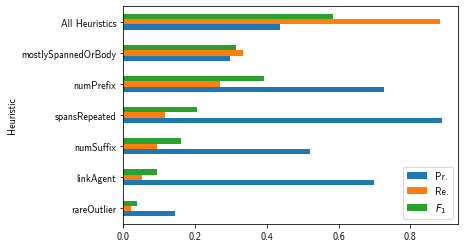

In [10]:
from matplotlib import rc
import matplotlib.pylab as plt

scores['Heuristic Pr. Re. $F_1$'.split()].set_index('Heuristic').plot.barh()

In [15]:
latex = scores['Heuristic Pr. Re. $F_1$'.split()].to_latex(index=None, escape=False, column_format='r|lll')
lines = [line for line in latex.splitlines() if line not in ['\\toprule', '\\bottomrule']]
lines.insert(-2, '\\midrule')
latex = '\n'.join(lines)
# latex = latex.replace('\midrule', '\hline')
with open('../paper/img/table-pivot-scores.tex', 'w') as fw:
    print(latex, file=fw)
print(latex)

\begin{tabular}{r|lll}
           Heuristic &  Pr. &  Re. &  $F_1$ \\
\midrule
         rareOutlier & 0.14 & 0.02 &   0.04 \\
           linkAgent & 0.70 & 0.05 &   0.09 \\
           numSuffix & 0.52 & 0.09 &   0.16 \\
       spansRepeated & 0.89 & 0.12 &   0.21 \\
           numPrefix & 0.73 & 0.27 &   0.39 \\
 mostlySpannedOrBody & 0.30 & 0.33 &   0.31 \\
\midrule
      All Heuristics & 0.44 & 0.88 &   0.58 \\
\end{tabular}


In [158]:
# Pivot debugging
output = ''
pred_heur = {t['headerId']:h for h,ts in heuristic_pivots.items() for t in ts if h != '\\textbf{combined}'}
allpred = makeset([t for _,ts in heuristic_pivots.items() for t in ts])
heur_pred = {h:makeset(ts) for h,ts in heuristic_pivots.items() if h != '\\textbf{combined}'}
gold = makeset(annotated_pivots)

def get_headerText(pgId, tbNr):
    t = db.cursor().execute("""
        SELECT GROUP_CONCAT(cellText) AS h
        FROM headers AS h
        JOIN tables AS t ON (h.headerId=t.headerId)
        WHERE (t.pgId=:pgId) AND (t.tbNr=:tbNr)
    """, {'pgId':pgId, 'tbNr':tbNr}).fetchone() or {}
    return t.get('h', '')

output += f'**False positives: ({len(allpred-gold)})**\n'
for heur, pred in heur_pred.items():
    for pgId, tbNr, h in pred - gold:
        t = get_headerText(pgId, tbNr).encode('unicode-escape').decode()
        output += f'- http://localhost:5000/table/{pgId}-{tbNr} ({pred_heur[h]}) <br>{t}\n'

output += f'\n**False negatives: ({len(gold-allpred)})**\n'
for pgId, tbNr, h in gold - allpred:
    t = get_headerText(pgId, tbNr)
    output += f'- http://localhost:5000/table/{pgId}-{tbNr} <br>{t}\n'


    
from IPython.display import display
display({'text/markdown': output}, raw=True)

**False positives: (158)**
- http://localhost:5000/table/4858143-2 (All Heuristics) <br>west division,gp,w,l,t,pts,gf,ga
- http://localhost:5000/table/24172049-4 (All Heuristics) <br>name,suburb/town,lga,opened,closed,notes
- http://localhost:5000/table/45611-2 (All Heuristics) <br>date of issue,a-side,b-side,label and catalogue number,album,uk singles chart placing and notes
- http://localhost:5000/table/203451-1 (All Heuristics) <br>factor ( s ),multiple,symbol,definition,comparative examples & common units,orders of magnitude
- http://localhost:5000/table/336388-1 (All Heuristics) <br>number,name,meaning,theater,comments
- http://localhost:5000/table/29636313-4 (All Heuristics) <br>year,winner,episode,recipient(s),network,other nominees
- http://localhost:5000/table/72735-2 (All Heuristics) <br>city district,extension km\xb2,population 2007 census(hab),housing (2007),density (hab/km\xb2),elevation msl
- http://localhost:5000/table/33338404-9 (All Heuristics) <br>date,player,club,return,ref
- http://localhost:5000/table/28879347-9 (All Heuristics) <br>crowd,home team,score,away team,score,ground,competition,round
- http://localhost:5000/table/7348002-24 (All Heuristics) <br>goals,player,match details
- http://localhost:5000/table/2443723-4 (All Heuristics) <br>season,class,motorcycle,type,races,win,podiums,pole,pts,position
- http://localhost:5000/table/4445687-1 (All Heuristics) <br>year,winner,age,jockey,trainer,owner,time
- http://localhost:5000/table/30297136-3 (All Heuristics) <br>week,week,date,date,kickoff,kickoff,opponent,opponent,results,final score,results,team record,game site,game site,tv,tv,nfl.com recap,nfl.com recap
- http://localhost:5000/table/38015288-4 (All Heuristics) <br>opponent,played,won,lost,drew,premiership points,points for,points against,percentage (%)
- http://localhost:5000/table/37506556-1 (All Heuristics) <br>pos,no,driver,constructor,laps,time/retired
- http://localhost:5000/table/17805778-1 (All Heuristics) <br>president,party,term,legislature
- http://localhost:5000/table/3948985-7 (All Heuristics) <br>aircraft,origin,type,versions,in service,notes
- http://localhost:5000/table/9919374-1 (All Heuristics) <br>club,town,first season,no. of seasons,no. of champions
- http://localhost:5000/table/28638-1 (All Heuristics) <br>polymer,abbreviation,properties,uses
- http://localhost:5000/table/18198445-2 (All Heuristics) <br>date,location,winner,score
- http://localhost:5000/table/21480056-8 (All Heuristics) <br>most valuable player,top scorer
- http://localhost:5000/table/426894-18 (All Heuristics) <br>country,country,library,city,legal deposit
- http://localhost:5000/table/712281-27 (All Heuristics) <br>winner,scores,loser
- http://localhost:5000/table/8456967-1 (All Heuristics) <br>year,car,start,qual,finish,laps,led,retired
- http://localhost:5000/table/39753188-3 (All Heuristics) <br>picture,model,origin,type,version,in service,notes
- http://localhost:5000/table/38822686-1 (All Heuristics) <br>week,week,date,date,opponent,opponent,results,final score,results,team record,game site,game site
- http://localhost:5000/table/22652800-4 (All Heuristics) <br>draw,team,period
- http://localhost:5000/table/10325318-5 (All Heuristics) <br>no,rider,team,motorcycle,tyre
- http://localhost:5000/table/2774779-1 (All Heuristics) <br>state,government,head of state united kingdom,head of government
- http://localhost:5000/table/17889786-1 (All Heuristics) <br>rank,banks,country
- http://localhost:5000/table/11946278-3 (All Heuristics) <br>#,title,writer,original airdate
- http://localhost:5000/table/38591124-5 (All Heuristics) <br>year,nominated work,category,result,winner
- http://localhost:5000/table/438737-4 (All Heuristics) <br>rank order,highest rank,branch,president,combat experience,service notes
- http://localhost:5000/table/7129521-2 (All Heuristics) <br>inmate name,register number,status,details
- http://localhost:5000/table/40171081-1 (All Heuristics) <br>season,winner,result,finalist,place
- http://localhost:5000/table/21451438-14 (All Heuristics) <br>biloxi,qiloqano,gloss
- http://localhost:5000/table/6403874-2 (All Heuristics) <br>year,play,playwright,role,theatre,notes
- http://localhost:5000/table/11240071-1 (All Heuristics) <br>gold,keiji suzuki japan (jpn)
- http://localhost:5000/table/28322003-1 (All Heuristics) <br>year,winner,country,score
- http://localhost:5000/table/8231096-2 (All Heuristics) <br>name,seasons,world championships,national championships,races,wins
- http://localhost:5000/table/32351113-2 (All Heuristics) <br>event,date,location,vacancies,qualified
- http://localhost:5000/table/6812428-1 (All Heuristics) <br>island,river
- http://localhost:5000/table/6786039-1 (All Heuristics) <br>rank,town,commune,canton,population (as of 2001[update] category:articles containing potentially dated statements from 2001 category:articles with invalid date parameter in template category:all articles containing potentially dated statements )
- http://localhost:5000/table/913927-3 (All Heuristics) <br>#,judge,state,born/died,active service,chief judge,senior status,appointed by,reason for termination
- http://localhost:5000/table/7491480-2 (All Heuristics) <br>ep,title,director,writer(s),original air date,taping date
- http://localhost:5000/table/427029-6 (All Heuristics) <br>year,university
- http://localhost:5000/table/25351788-1 (All Heuristics) <br>year,class,no,tyres,car,team,co-drivers,laps,pos.,class pos.
- http://localhost:5000/table/20739199-1 (All Heuristics) <br>year,winner,school
- http://localhost:5000/table/11694021-1 (All Heuristics) <br>pos,no,team,driver,car,hh,qual
- http://localhost:5000/table/447260-1 (All Heuristics) <br>mi,km
- http://localhost:5000/table/2695055-1 (All Heuristics) <br>zone,men,women
- http://localhost:5000/table/18993809-1 (All Heuristics) <br>date,opponent,f,a,venue,city,winner
- http://localhost:5000/table/1980690-1 (All Heuristics) <br>city served / location,icao,iata,airport name,coordinates
- http://localhost:5000/table/2858718-4 (All Heuristics) <br>episode #,title,recording number,original airdate,producer,scriptwriter(s),notes
- http://localhost:5000/table/10539301-1 (All Heuristics) <br>name,coordinates
- http://localhost:5000/table/2016467-2 (All Heuristics) <br>miles from atlantic terminal,name,location,opened,closed
- http://localhost:5000/table/28343141-1 (All Heuristics) <br>tanks,origin,type,versions,in service,notes
- http://localhost:5000/table/10496814-2 (All Heuristics) <br>name,location,diameter,age,coordinates
- http://localhost:5000/table/25704946-6 (All Heuristics) <br>celebrity,position on strictly,professional,judge's score,dance,song
- http://localhost:5000/table/2809984-3 (All Heuristics) <br>location,year,champions,runners-up,score
- http://localhost:5000/table/11245446-10 (All Heuristics) <br>year,venue,score,score,runner-up,notes
- http://localhost:5000/table/17571201-4 (All Heuristics) <br>individual,category,year,years with ducks
- http://localhost:5000/table/10329042-40 (All Heuristics) <br>precipitation,rank,precipitation,mm,precipitation,in,storm,storm,location,location,ref,ref
- http://localhost:5000/table/2561323-20 (All Heuristics) <br>affiliations,graduate,attendee or researcher,academic staff before or at the time of award,academic staff after award
- http://localhost:5000/table/10016109-1 (All Heuristics) <br>station,japanese,distance (km),distance between stations,date opened,location
- http://localhost:5000/table/11622006-3 (All Heuristics) <br>rank,player,country,earnings ( $ ),events,wins
- http://localhost:5000/table/34043842-2 (All Heuristics) <br>rank,player,country,events,prize money ( \u20ac )
- http://localhost:5000/table/11033890-2 (All Heuristics) <br>designation,type,weight,content weight,content type,construction,length,suspension lugs,nose,tail,fuze,notes
- http://localhost:5000/table/1122557-4 (All Heuristics) <br>previousrace: 1972 german grand prix,fia formula one world championship 1972 season,nextrace: 1972 italian grand prix
- http://localhost:5000/table/4241156-3 (All Heuristics) <br>date,location,race,winner,country
- http://localhost:5000/table/32020000-1 (All Heuristics) <br>year,venue,winner,country,score,runner(s)-up
- http://localhost:5000/table/24619829-1 (All Heuristics) <br>inventor,# of patent families,country,# of inpadoc patents,lived,main fields of invention,ref
- http://localhost:5000/table/28837569-1 (All Heuristics) <br>townland,acres,barony,civil parish,poor law union
- http://localhost:5000/table/362310-2 (All Heuristics) <br>name,period,duchess,notes,other titles
- http://localhost:5000/table/18624683-1 (All Heuristics) <br>world record,grant hackett ( aus ),14:34.56,fukuoka , japan,29 july 2001
- http://localhost:5000/table/30483341-8 (All Heuristics) <br>star,score,song
- http://localhost:5000/table/36187545-3 (All Heuristics) <br>no.,barrio,population ( census 2000 ),density (/sqmi),total area (sqmi),land area (sqmi),water area (sqmi)
- http://localhost:5000/table/22214856-1 (All Heuristics) <br>date,ship,home port,action,saved
- http://localhost:5000/table/38153770-5 (All Heuristics) <br>previousrace: 2013 belgian grand prix,fia formula one world championship 2013 season,nextrace: 2013 singapore grand prix
- http://localhost:5000/table/37097284-1 (All Heuristics) <br>team,winner,winning years
- http://localhost:5000/table/13955731-4 (All Heuristics) <br>#,date,opponent,score,win,loss,save,attendance,record
- http://localhost:5000/table/1122106-1 (All Heuristics) <br>year,web browsers,internet users (in millions)
- http://localhost:5000/table/15581315-2 (All Heuristics) <br>name,novelty,status,authors,age,unit,location,notes,images
- http://localhost:5000/table/592300-3 (All Heuristics) <br>loco,final depot,industrial career,dates,disposal
- http://localhost:5000/table/39940899-15 (All Heuristics) <br>singer,song,result,number of votes
- http://localhost:5000/table/22722823-4 (All Heuristics) <br>player,min,gp,w,l,t,ga,gaa,sa,so
- http://localhost:5000/table/36793291-12 (All Heuristics) <br>finalist,assistants,theme
- http://localhost:5000/table/5630637-7 (All Heuristics) <br>tour,date,city,venue
- http://localhost:5000/table/30794146-1 (All Heuristics) <br>gold,jonathan edwards great britain (gbr)
- http://localhost:5000/table/26220236-2 (All Heuristics) <br>aircraft,orders,deliveries,in operation
- http://localhost:5000/table/25032095-4 (All Heuristics) <br>2013,institute,region
- http://localhost:5000/table/3354815-2 (All Heuristics) <br>\u2116,title,airdate,pc
- http://localhost:5000/table/3114745-2 (All Heuristics) <br>name,nation,view,population,mayor or governor|n/a
- http://localhost:5000/table/10231194-1 (All Heuristics) <br>name of parish,total population 5 and older,french-speaking population 5 and older,percentage french-speaking,map
- http://localhost:5000/table/33895892-3 (All Heuristics) <br>means of qualification,berths,qualified
- http://localhost:5000/table/5185915-1 (All Heuristics) <br>number,government,statutes,time in office
- http://localhost:5000/table/1740593-1 (All Heuristics) <br>evershed,latitude,longitude,diameter
- http://localhost:5000/table/39352706-5 (All Heuristics) <br>place,player,country,to par,thru
- http://localhost:5000/table/913625-2 (All Heuristics) <br>outcome,year,championship,surface,opponent in the final,score in the final
- http://localhost:5000/table/14049739-1 (All Heuristics) <br>gold,mike powell united states (usa)
- http://localhost:5000/table/7078635-2 (All Heuristics) <br>affiliation,affiliation,election,today
- http://localhost:5000/table/40402593-3 (All Heuristics) <br>it.,nga /int number,location,coordinates,light characteristic,height (ft/m) range (nmi),structure description,height (ft),remarks
- http://localhost:5000/table/38301087-3 (All Heuristics) <br>year,person,top ten,ref.
- http://localhost:5000/table/20790934-2 (All Heuristics) <br>name,division,years in office,elected
- http://localhost:5000/table/23645664-2 (All Heuristics) <br>season,season,league,league,regular season,gp,regular season,w,regular season,l,regular season,t,regular season,otw,regular season,otl,regular season,gf,regular season,ga,regular season,pts,regular season,finish,postseason,postseason
- http://localhost:5000/table/25829076-3 (All Heuristics) <br>station/ location,station link,miles (kilometers) to penn station,connections/notes,history
- http://localhost:5000/table/19463191-1 (All Heuristics) <br>pos,start,car #,driver/hometown,sponsor/make,laps,winnings (in us$ ),status
- http://localhost:5000/table/18841575-1 (All Heuristics) <br>year,winner,1st runner up,2nd runner up
- http://localhost:5000/table/24240402-3 (All Heuristics) <br>pos,no,rider,manufacturer,laps,time,grid,points
- http://localhost:5000/table/4858143-2 (All Heuristics) <br>west division,gp,w,l,t,pts,gf,ga
- http://localhost:5000/table/1945375-1 (numSuffix) <br>precededby roel sanders,drummer for god dethroned 2001\u20132008,succeededby roel sanders
- http://localhost:5000/table/24172049-4 (All Heuristics) <br>name,suburb/town,lga,opened,closed,notes
- http://localhost:5000/table/7385901-4 (numSuffix) <br>event,athlete,time,penalties,adjusted time 1,rank
- http://localhost:5000/table/45611-2 (All Heuristics) <br>date of issue,a-side,b-side,label and catalogue number,album,uk singles chart placing and notes
- http://localhost:5000/table/203451-1 (All Heuristics) <br>factor ( s ),multiple,symbol,definition,comparative examples & common units,orders of magnitude
- http://localhost:5000/table/336388-1 (All Heuristics) <br>number,name,meaning,theater,comments
- http://localhost:5000/table/29636313-4 (All Heuristics) <br>year,winner,episode,recipient(s),network,other nominees
- http://localhost:5000/table/72735-2 (All Heuristics) <br>city district,extension km\xb2,population 2007 census(hab),housing (2007),density (hab/km\xb2),elevation msl
- http://localhost:5000/table/18302648-1 (rareOutlier) <br>position,player,current club
- http://localhost:5000/table/33338404-9 (All Heuristics) <br>date,player,club,return,ref
- http://localhost:5000/table/9541016-1 (rareOutlier) <br>preceding station,line,line,line,following station
- http://localhost:5000/table/28879347-9 (All Heuristics) <br>crowd,home team,score,away team,score,ground,competition,round
- http://localhost:5000/table/7348002-24 (All Heuristics) <br>goals,player,match details
- http://localhost:5000/table/39891144-6 (numSuffix) <br>athlete,athlete,event,event,preliminary round,opposition score,round of 32,opposition score
- http://localhost:5000/table/2443723-4 (All Heuristics) <br>season,class,motorcycle,type,races,win,podiums,pole,pts,position
- http://localhost:5000/table/4445687-1 (All Heuristics) <br>year,winner,age,jockey,trainer,owner,time
- http://localhost:5000/table/30297136-3 (All Heuristics) <br>week,week,date,date,kickoff,kickoff,opponent,opponent,results,final score,results,team record,game site,game site,tv,tv,nfl.com recap,nfl.com recap
- http://localhost:5000/table/38015288-4 (All Heuristics) <br>opponent,played,won,lost,drew,premiership points,points for,points against,percentage (%)
- http://localhost:5000/table/36148074-1 (rareOutlier) <br>preceding station,connections,connections,connections,following station
- http://localhost:5000/table/37506556-1 (All Heuristics) <br>pos,no,driver,constructor,laps,time/retired
- http://localhost:5000/table/1811443-22 (numPrefix) <br>party,party,candidate,1st pref,%,seat,count
- http://localhost:5000/table/17805778-1 (All Heuristics) <br>president,party,term,legislature
- http://localhost:5000/table/19130829-1 (numPrefix) <br>team #1,agg. score,team #2,1st leg,2nd leg
- http://localhost:5000/table/3948985-7 (All Heuristics) <br>aircraft,origin,type,versions,in service,notes
- http://localhost:5000/table/9919374-1 (All Heuristics) <br>club,town,first season,no. of seasons,no. of champions
- http://localhost:5000/table/28638-1 (All Heuristics) <br>polymer,abbreviation,properties,uses
- http://localhost:5000/table/18198445-2 (All Heuristics) <br>date,location,winner,score
- http://localhost:5000/table/21480056-8 (All Heuristics) <br>most valuable player,top scorer
- http://localhost:5000/table/426894-18 (All Heuristics) <br>country,country,library,city,legal deposit
- http://localhost:5000/table/712281-27 (All Heuristics) <br>winner,scores,loser
- http://localhost:5000/table/39483008-5 (rareOutlier) <br>choice,votes,%
- http://localhost:5000/table/3205442-1 (rareOutlier) <br>preceding station,national rail,national rail,national rail,following station
- http://localhost:5000/table/8456967-1 (All Heuristics) <br>year,car,start,qual,finish,laps,led,retired
- http://localhost:5000/table/37364606-16 (numSuffix) <br>position,round 16 - 2012,p,w,d,l,for,against,diff,points
- http://localhost:5000/table/39753188-3 (All Heuristics) <br>picture,model,origin,type,version,in service,notes
- http://localhost:5000/table/22652800-4 (All Heuristics) <br>draw,team,period
- http://localhost:5000/table/38822686-1 (All Heuristics) <br>week,week,date,date,opponent,opponent,results,final score,results,team record,game site,game site
- http://localhost:5000/table/10325318-5 (All Heuristics) <br>no,rider,team,motorcycle,tyre
- http://localhost:5000/table/13601114-1 (numPrefix) <br>year,team,gp,gs,mpg,fg%,3p%,ft%,rpg,apg,spg,bpg,ppg
- http://localhost:5000/table/2774779-1 (All Heuristics) <br>state,government,head of state united kingdom,head of government
- http://localhost:5000/table/12982400-1 (rareOutlier) <br>preceding station,link light rail,following station
- http://localhost:5000/table/28075357-5 (rareOutlier) <br>rank,name,nationality,time (hand),notes
- http://localhost:5000/table/17889786-1 (All Heuristics) <br>rank,banks,country
- http://localhost:5000/table/11946278-3 (All Heuristics) <br>#,title,writer,original airdate
- http://localhost:5000/table/12736926-8 (numSuffix) <br>july 22, 1988,to washington capitals geoff courtnall,to edmonton oilers greg adams
- http://localhost:5000/table/40366416-2 (rareOutlier) <br>rank,name,floors,year,notes
- http://localhost:5000/table/38767157-1 (numPrefix) <br>name,hometown,high school / college,height,weight,40\u2021,commit date
- http://localhost:5000/table/38591124-5 (All Heuristics) <br>year,nominated work,category,result,winner
- http://localhost:5000/table/438737-4 (All Heuristics) <br>rank order,highest rank,branch,president,combat experience,service notes
- http://localhost:5000/table/7129521-2 (All Heuristics) <br>inmate name,register number,status,details
- http://localhost:5000/table/40171081-1 (All Heuristics) <br>season,winner,result,finalist,place
- http://localhost:5000/table/6646457-1 (numSuffix) <br>date,team 1,team 2,score,competition,goalscorers,attendance
- http://localhost:5000/table/21451438-14 (All Heuristics) <br>biloxi,qiloqano,gloss
- http://localhost:5000/table/6403874-2 (All Heuristics) <br>year,play,playwright,role,theatre,notes
- http://localhost:5000/table/11240071-1 (All Heuristics) <br>gold,keiji suzuki japan (jpn)
- http://localhost:5000/table/28322003-1 (All Heuristics) <br>year,winner,country,score
- http://localhost:5000/table/24566054-5 (numPrefix) <br>4th son,hrh the prince george, duke of kent,20 december 1902 25 august 1942 (aged39)
- http://localhost:5000/table/8231096-2 (All Heuristics) <br>name,seasons,world championships,national championships,races,wins
- http://localhost:5000/table/32351113-2 (All Heuristics) <br>event,date,location,vacancies,qualified
- http://localhost:5000/table/6812428-1 (All Heuristics) <br>island,river
- http://localhost:5000/table/40006848-1 (numSuffix) <br>country,player,rank 1,seed
- http://localhost:5000/table/6786039-1 (All Heuristics) <br>rank,town,commune,canton,population (as of 2001[update] category:articles containing potentially dated statements from 2001 category:articles with invalid date parameter in template category:all articles containing potentially dated statements )
- http://localhost:5000/table/913927-3 (All Heuristics) <br>#,judge,state,born/died,active service,chief judge,senior status,appointed by,reason for termination
- http://localhost:5000/table/12200927-16 (rareOutlier) <br>position,judoka,country
- http://localhost:5000/table/34163591-34 (spansRepeated) <br>athlete,athlete,event,event,ski jumping,points,ski jumping,rank,cross-country,deficit,cross-country,ski time,final,total time,final,rank
- http://localhost:5000/table/7106086-1 (rareOutlier) <br>preceding station,historical railways,historical railways,historical railways,following station
- http://localhost:5000/table/7491480-2 (All Heuristics) <br>ep,title,director,writer(s),original air date,taping date
- http://localhost:5000/table/427029-6 (All Heuristics) <br>year,university
- http://localhost:5000/table/25351788-1 (All Heuristics) <br>year,class,no,tyres,car,team,co-drivers,laps,pos.,class pos.
- http://localhost:5000/table/1754686-3 (linkAgent) <br>preceding station,transperth trains network,following station
- http://localhost:5000/table/13844329-6 (numSuffix) <br>team 1,team 2,res.
- http://localhost:5000/table/20739199-1 (All Heuristics) <br>year,winner,school
- http://localhost:5000/table/1767997-7 (numPrefix) <br>1982 alberta general election results,1982 alberta general election results,1982 alberta general election results,turnout 62.36%,turnout 62.36%,swing,swing
- http://localhost:5000/table/11694021-1 (All Heuristics) <br>pos,no,team,driver,car,hh,qual
- http://localhost:5000/table/447260-1 (All Heuristics) <br>mi,km
- http://localhost:5000/table/36579524-2 (numPrefix) <br>team 1,agg.,team 2,1st leg,2nd leg
- http://localhost:5000/table/2695055-1 (All Heuristics) <br>zone,men,women
- http://localhost:5000/table/31623267-5 (numPrefix) <br>teams,team 1,teams,points,teams,team 2,scores,1st leg,scores,2nd leg,tie-breaker,3rd leg
- http://localhost:5000/table/18993809-1 (All Heuristics) <br>date,opponent,f,a,venue,city,winner
- http://localhost:5000/table/1980690-1 (All Heuristics) <br>city served / location,icao,iata,airport name,coordinates
- http://localhost:5000/table/1779701-1 (rareOutlier) <br>preceding station,national rail,national rail,national rail,following station
- http://localhost:5000/table/2858718-4 (All Heuristics) <br>episode #,title,recording number,original airdate,producer,scriptwriter(s),notes
- http://localhost:5000/table/10539301-1 (All Heuristics) <br>name,coordinates
- http://localhost:5000/table/2016467-2 (All Heuristics) <br>miles from atlantic terminal,name,location,opened,closed
- http://localhost:5000/table/3533752-2 (rareOutlier) <br>#,side one,time
- http://localhost:5000/table/13878045-1 (linkAgent) <br>nl west,w,l,gb,pct.
- http://localhost:5000/table/28343141-1 (All Heuristics) <br>tanks,origin,type,versions,in service,notes
- http://localhost:5000/table/10496814-2 (All Heuristics) <br>name,location,diameter,age,coordinates
- http://localhost:5000/table/30016644-4 (rareOutlier) <br>team,skip,w,l
- http://localhost:5000/table/25704946-6 (All Heuristics) <br>celebrity,position on strictly,professional,judge's score,dance,song
- http://localhost:5000/table/2809984-3 (All Heuristics) <br>location,year,champions,runners-up,score
- http://localhost:5000/table/11245446-10 (All Heuristics) <br>year,venue,score,score,runner-up,notes
- http://localhost:5000/table/17571201-4 (All Heuristics) <br>individual,category,year,years with ducks
- http://localhost:5000/table/10329042-40 (All Heuristics) <br>precipitation,rank,precipitation,mm,precipitation,in,storm,storm,location,location,ref,ref
- http://localhost:5000/table/2561323-20 (All Heuristics) <br>affiliations,graduate,attendee or researcher,academic staff before or at the time of award,academic staff after award
- http://localhost:5000/table/10016109-1 (All Heuristics) <br>station,japanese,distance (km),distance between stations,date opened,location
- http://localhost:5000/table/11307315-1 (rareOutlier) <br>preceding station,disused railways,disused railways,disused railways,following station
- http://localhost:5000/table/11622006-3 (All Heuristics) <br>rank,player,country,earnings ( $ ),events,wins
- http://localhost:5000/table/34043842-2 (All Heuristics) <br>rank,player,country,events,prize money ( \u20ac )
- http://localhost:5000/table/11033890-2 (All Heuristics) <br>designation,type,weight,content weight,content type,construction,length,suspension lugs,nose,tail,fuze,notes
- http://localhost:5000/table/2218832-4 (spansRepeated) <br>classical/katharevousa,greek alphabet,classical/katharevousa,transliteration,modern greek,greek alphabet,modern greek,transliteration,modern greek,ipa,english,english
- http://localhost:5000/table/5565708-1 (rareOutlier) <br>preceding station,national rail,national rail,national rail,following station
- http://localhost:5000/table/1122557-4 (All Heuristics) <br>previousrace: 1972 german grand prix,fia formula one world championship 1972 season,nextrace: 1972 italian grand prix
- http://localhost:5000/table/4241156-3 (All Heuristics) <br>date,location,race,winner,country
- http://localhost:5000/table/32020000-1 (All Heuristics) <br>year,venue,winner,country,score,runner(s)-up
- http://localhost:5000/table/2140677-16 (numPrefix) <br>1st party,2nd party,timespan,source
- http://localhost:5000/table/24619829-1 (All Heuristics) <br>inventor,# of patent families,country,# of inpadoc patents,lived,main fields of invention,ref
- http://localhost:5000/table/28837569-1 (All Heuristics) <br>townland,acres,barony,civil parish,poor law union
- http://localhost:5000/table/362310-2 (All Heuristics) <br>name,period,duchess,notes,other titles
- http://localhost:5000/table/18624683-1 (All Heuristics) <br>world record,grant hackett ( aus ),14:34.56,fukuoka , japan,29 july 2001
- http://localhost:5000/table/30483341-8 (All Heuristics) <br>star,score,song
- http://localhost:5000/table/8128090-1 (rareOutlier) <br>preceding station,historical railways,historical railways,historical railways,following station
- http://localhost:5000/table/14938664-26 (numPrefix) <br>category,2003 recipient,location
- http://localhost:5000/table/36187545-3 (All Heuristics) <br>no.,barrio,population ( census 2000 ),density (/sqmi),total area (sqmi),land area (sqmi),water area (sqmi)
- http://localhost:5000/table/22214856-1 (All Heuristics) <br>date,ship,home port,action,saved
- http://localhost:5000/table/38153770-5 (All Heuristics) <br>previousrace: 2013 belgian grand prix,fia formula one world championship 2013 season,nextrace: 2013 singapore grand prix
- http://localhost:5000/table/37097284-1 (All Heuristics) <br>team,winner,winning years
- http://localhost:5000/table/13955731-4 (All Heuristics) <br>#,date,opponent,score,win,loss,save,attendance,record
- http://localhost:5000/table/21548868-8 (rareOutlier) <br>candidate,candidate,party,symbol,votes,%
- http://localhost:5000/table/1122106-1 (All Heuristics) <br>year,web browsers,internet users (in millions)
- http://localhost:5000/table/15581315-2 (All Heuristics) <br>name,novelty,status,authors,age,unit,location,notes,images
- http://localhost:5000/table/592300-3 (All Heuristics) <br>loco,final depot,industrial career,dates,disposal
- http://localhost:5000/table/21638368-5 (rareOutlier) <br>candidate,candidate,party,symbol,votes,%
- http://localhost:5000/table/3069464-1 (numPrefix) <br>year,team,gp,mpg,fg%,3p%,ft%,rpg,apg,spg,bpg,ppg
- http://localhost:5000/table/39940899-15 (All Heuristics) <br>singer,song,result,number of votes
- http://localhost:5000/table/22722823-4 (All Heuristics) <br>player,min,gp,w,l,t,ga,gaa,sa,so
- http://localhost:5000/table/36793291-12 (All Heuristics) <br>finalist,assistants,theme
- http://localhost:5000/table/5630637-7 (All Heuristics) <br>tour,date,city,venue
- http://localhost:5000/table/30794146-1 (All Heuristics) <br>gold,jonathan edwards great britain (gbr)
- http://localhost:5000/table/26220236-2 (All Heuristics) <br>aircraft,orders,deliveries,in operation
- http://localhost:5000/table/28493748-1 (linkAgent) <br>year,player,team
- http://localhost:5000/table/25032095-4 (All Heuristics) <br>2013,institute,region
- http://localhost:5000/table/3354815-2 (All Heuristics) <br>\u2116,title,airdate,pc
- http://localhost:5000/table/3114745-2 (All Heuristics) <br>name,nation,view,population,mayor or governor|n/a
- http://localhost:5000/table/10231194-1 (All Heuristics) <br>name of parish,total population 5 and older,french-speaking population 5 and older,percentage french-speaking,map
- http://localhost:5000/table/33895892-3 (All Heuristics) <br>means of qualification,berths,qualified
- http://localhost:5000/table/5185915-1 (All Heuristics) <br>number,government,statutes,time in office
- http://localhost:5000/table/1740593-1 (All Heuristics) <br>evershed,latitude,longitude,diameter
- http://localhost:5000/table/39352706-5 (All Heuristics) <br>place,player,country,to par,thru
- http://localhost:5000/table/913625-2 (All Heuristics) <br>outcome,year,championship,surface,opponent in the final,score in the final
- http://localhost:5000/table/14049739-1 (All Heuristics) <br>gold,mike powell united states (usa)
- http://localhost:5000/table/25836960-1 (numSuffix) <br>year 2,production,grade,cost per ounce
- http://localhost:5000/table/717943-1 (numSuffix) <br>park name,county or counties,area in acres (ha),date estab- lished :297,body of water,coordinates,remarks,image
- http://localhost:5000/table/23083016-4 (numPrefix) <br>number of teams,points difference,4th,5th,2nd-last,last
- http://localhost:5000/table/35712507-2 (numPrefix) <br>no.,title,air date,18\u201349 rating (live + sd),viewers (millions) increase,total 18-49 increase,total viewers (millions),ref
- http://localhost:5000/table/7078635-2 (All Heuristics) <br>affiliation,affiliation,election,today
- http://localhost:5000/table/30892853-1 (numSuffix) <br>rank,bib,name,nation,run 1,rank,run 2,rank,total,difference
- http://localhost:5000/table/40402593-3 (All Heuristics) <br>it.,nga /int number,location,coordinates,light characteristic,height (ft/m) range (nmi),structure description,height (ft),remarks
- http://localhost:5000/table/38301087-3 (All Heuristics) <br>year,person,top ten,ref.
- http://localhost:5000/table/7712111-1 (numSuffix) <br>precededby " our day will come " by ruby and the romantics,billboard hot 100 number one single march 30, 1963 - april 20, 1963,succeededby " i will follow him " by little peggy march
- http://localhost:5000/table/20790934-2 (All Heuristics) <br>name,division,years in office,elected
- http://localhost:5000/table/23645664-2 (All Heuristics) <br>season,season,league,league,regular season,gp,regular season,w,regular season,l,regular season,t,regular season,otw,regular season,otl,regular season,gf,regular season,ga,regular season,pts,regular season,finish,postseason,postseason
- http://localhost:5000/table/25829076-3 (All Heuristics) <br>station/ location,station link,miles (kilometers) to penn station,connections/notes,history
- http://localhost:5000/table/19463191-1 (All Heuristics) <br>pos,start,car #,driver/hometown,sponsor/make,laps,winnings (in us$ ),status
- http://localhost:5000/table/2216478-1 (numPrefix) <br>name,2010 census population
- http://localhost:5000/table/18841575-1 (All Heuristics) <br>year,winner,1st runner up,2nd runner up
- http://localhost:5000/table/24240402-3 (All Heuristics) <br>pos,no,rider,manufacturer,laps,time,grid,points
- http://localhost:5000/table/24566054-5 (numPrefix) <br>4th son,hrh the prince george, duke of kent,20 december 1902 25 august 1942 (aged39)
- http://localhost:5000/table/1767997-7 (numPrefix) <br>1982 alberta general election results,1982 alberta general election results,1982 alberta general election results,turnout 62.36%,turnout 62.36%,swing,swing
- http://localhost:5000/table/36579524-2 (numPrefix) <br>team 1,agg.,team 2,1st leg,2nd leg
- http://localhost:5000/table/38767157-1 (numPrefix) <br>name,hometown,high school / college,height,weight,40\u2021,commit date
- http://localhost:5000/table/1811443-22 (numPrefix) <br>party,party,candidate,1st pref,%,seat,count
- http://localhost:5000/table/2140677-16 (numPrefix) <br>1st party,2nd party,timespan,source
- http://localhost:5000/table/23083016-4 (numPrefix) <br>number of teams,points difference,4th,5th,2nd-last,last
- http://localhost:5000/table/14938664-26 (numPrefix) <br>category,2003 recipient,location
- http://localhost:5000/table/3069464-1 (numPrefix) <br>year,team,gp,mpg,fg%,3p%,ft%,rpg,apg,spg,bpg,ppg
- http://localhost:5000/table/19130829-1 (numPrefix) <br>team #1,agg. score,team #2,1st leg,2nd leg
- http://localhost:5000/table/13601114-1 (numPrefix) <br>year,team,gp,gs,mpg,fg%,3p%,ft%,rpg,apg,spg,bpg,ppg
- http://localhost:5000/table/2216478-1 (numPrefix) <br>name,2010 census population
- http://localhost:5000/table/35712507-2 (numPrefix) <br>no.,title,air date,18\u201349 rating (live + sd),viewers (millions) increase,total 18-49 increase,total viewers (millions),ref
- http://localhost:5000/table/31623267-5 (numPrefix) <br>teams,team 1,teams,points,teams,team 2,scores,1st leg,scores,2nd leg,tie-breaker,3rd leg
- http://localhost:5000/table/13844329-6 (numSuffix) <br>team 1,team 2,res.
- http://localhost:5000/table/1945375-1 (numSuffix) <br>precededby roel sanders,drummer for god dethroned 2001\u20132008,succeededby roel sanders
- http://localhost:5000/table/30892853-1 (numSuffix) <br>rank,bib,name,nation,run 1,rank,run 2,rank,total,difference
- http://localhost:5000/table/25836960-1 (numSuffix) <br>year 2,production,grade,cost per ounce
- http://localhost:5000/table/12736926-8 (numSuffix) <br>july 22, 1988,to washington capitals geoff courtnall,to edmonton oilers greg adams
- http://localhost:5000/table/717943-1 (numSuffix) <br>park name,county or counties,area in acres (ha),date estab- lished :297,body of water,coordinates,remarks,image
- http://localhost:5000/table/7712111-1 (numSuffix) <br>precededby " our day will come " by ruby and the romantics,billboard hot 100 number one single march 30, 1963 - april 20, 1963,succeededby " i will follow him " by little peggy march
- http://localhost:5000/table/37364606-16 (numSuffix) <br>position,round 16 - 2012,p,w,d,l,for,against,diff,points
- http://localhost:5000/table/40006848-1 (numSuffix) <br>country,player,rank 1,seed
- http://localhost:5000/table/7385901-4 (numSuffix) <br>event,athlete,time,penalties,adjusted time 1,rank
- http://localhost:5000/table/6646457-1 (numSuffix) <br>date,team 1,team 2,score,competition,goalscorers,attendance
- http://localhost:5000/table/39891144-6 (numSuffix) <br>athlete,athlete,event,event,preliminary round,opposition score,round of 32,opposition score
- http://localhost:5000/table/28493748-1 (linkAgent) <br>year,player,team
- http://localhost:5000/table/1754686-3 (linkAgent) <br>preceding station,transperth trains network,following station
- http://localhost:5000/table/13878045-1 (linkAgent) <br>nl west,w,l,gb,pct.
- http://localhost:5000/table/28075357-5 (rareOutlier) <br>rank,name,nationality,time (hand),notes
- http://localhost:5000/table/21548868-8 (rareOutlier) <br>candidate,candidate,party,symbol,votes,%
- http://localhost:5000/table/30016644-4 (rareOutlier) <br>team,skip,w,l
- http://localhost:5000/table/36148074-1 (rareOutlier) <br>preceding station,connections,connections,connections,following station
- http://localhost:5000/table/11307315-1 (rareOutlier) <br>preceding station,disused railways,disused railways,disused railways,following station
- http://localhost:5000/table/1779701-1 (rareOutlier) <br>preceding station,national rail,national rail,national rail,following station
- http://localhost:5000/table/5565708-1 (rareOutlier) <br>preceding station,national rail,national rail,national rail,following station
- http://localhost:5000/table/40366416-2 (rareOutlier) <br>rank,name,floors,year,notes
- http://localhost:5000/table/39483008-5 (rareOutlier) <br>choice,votes,%
- http://localhost:5000/table/3205442-1 (rareOutlier) <br>preceding station,national rail,national rail,national rail,following station
- http://localhost:5000/table/8128090-1 (rareOutlier) <br>preceding station,historical railways,historical railways,historical railways,following station
- http://localhost:5000/table/12982400-1 (rareOutlier) <br>preceding station,link light rail,following station
- http://localhost:5000/table/3533752-2 (rareOutlier) <br>#,side one,time
- http://localhost:5000/table/18302648-1 (rareOutlier) <br>position,player,current club
- http://localhost:5000/table/9541016-1 (rareOutlier) <br>preceding station,line,line,line,following station
- http://localhost:5000/table/21638368-5 (rareOutlier) <br>candidate,candidate,party,symbol,votes,%
- http://localhost:5000/table/12200927-16 (rareOutlier) <br>position,judoka,country
- http://localhost:5000/table/7106086-1 (rareOutlier) <br>preceding station,historical railways,historical railways,historical railways,following station
- http://localhost:5000/table/34163591-34 (spansRepeated) <br>athlete,athlete,event,event,ski jumping,points,ski jumping,rank,cross-country,deficit,cross-country,ski time,final,total time,final,rank
- http://localhost:5000/table/2218832-4 (spansRepeated) <br>classical/katharevousa,greek alphabet,classical/katharevousa,transliteration,modern greek,greek alphabet,modern greek,transliteration,modern greek,ipa,english,english

**False negatives: (16)**
- http://localhost:5000/table/18789571-18 <br>event,gold,silver,bronze
- http://localhost:5000/table/30347794-2 <br>event,gold,silver,bronze
- http://localhost:5000/table/12630817-9 <br>rank,name,tfp,sp,fs
- http://localhost:5000/table/5849118-6 <br>year,year,album details,album details,peak chart positions,us,certifications ( sales thresholds ),certifications ( sales thresholds )
- http://localhost:5000/table/36227938-19 <br>group a,group b
- http://localhost:5000/table/8580581-1 <br>source,date,beatty (r),kerry (d)
- http://localhost:5000/table/4908802-2 <br>ireland,russia,germany,france
- http://localhost:5000/table/38073151-17 <br>united states – 3,player,united states – 3,score,new zealand – 0,player,new zealand – 0,score
- http://localhost:5000/table/17748015-1 <br>gold,silver,bronze
- http://localhost:5000/table/38636702-1 <br>overall,pld,overall,w,overall,d,overall,l,overall,gf,overall,ga,overall,gd,overall,pts,home,w,home,l,home,gf,home,ga,home,gd,away,w,away,d,away,l,away,gf,away,ga,away,gd
- http://localhost:5000/table/30671550-2 <br>event,gold,gold,silver,silver,bronze,bronze
- http://localhost:5000/table/39802374-5 <br>overall,pld,overall,w,overall,d,overall,l,overall,gf,overall,ga,overall,gd,overall,pts,home,w,home,d,home,gf,home,ga,home,gd,away,w,away,l,away,gf,away,ga,away,gd
- http://localhost:5000/table/10648331-2 <br>event,gold,gold,silver,silver,bronze,bronze
- http://localhost:5000/table/4797477-1 <br>next island upstream,river thames,next island downstream
- http://localhost:5000/table/33930104-1 <br>season,short program,free skating
- http://localhost:5000/table/6527796-6 <br>team,city,existed,s avco cup,notes
